# Extracting extended line emission from SMA data of disks

### Authors
Joshua Lovell (joshualovellastro@gmail.com); June 2024. 

_Special thanks to K. Monsch for providing access to scripts from Monsch et al. 2024 for verification purposes._

### Aims & Objectives
In this tutorial, we are aiming to replicate various plots from the recent SMA paper: 
'High-resolution Pan-STARRS and SMA observations of IRAS 23077+6707: A giant edge-on protoplanetary disk' [https://arxiv.org/abs/2402.01941]

For demonstrating this example, we are just going to use the C18O line data -- the isotopologue of Carbon Monoxide -- which was the faintest
of the three CO lines measured in that work. 

Our aim is to:

1-- understand the structure of a 'data cube', how we can access different information that this hosts, and how to stack this data up in 
different ways (e.g., making 'moment' maps);

2-- successfully replicate figures 1, and 2 (for the C18O line) from Monsch et al.;

3-- understand how different choices made during the analyses of Monsch et al. would have impacted this line detection;

4-- extend the analyses done in this work, and measure to see if the line hosts any level of emission asymmetry.

So, like in all python scripts let's load in all libraries...

### Requirements

In [32]:
##local copy of 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image.fits' -- this is the SMA data cube for the C18O line
#pip install astropy
#pip install gofish
#pip install matplotlib
#pip install bettermoments
#pip install seaborn
#pip install cmocean

# Tutorial

## Stage A: Setup our workspace
### Step A1: collect all relevent libraries

We will start by importing all relevant libraries for this tutorial. All of the relevant packages should have been installed via pip in the previous step.

In [33]:
%matplotlib inline
import gofish
import numpy as np
import matplotlib.pyplot as plt
from gofish import imagecube
import bettermoments as bm
import astropy.io.fits as pyfits
import cmocean
import seaborn as sns

### Step A2: import required data

Next we want to import the data -- here we have chosen a C18O data cube from the SMA analysis of Monsch et al. 2024.
In that work a line spectrum is presented for three different CO cubes, including this (faintest) line.

In this tutorial we will use 'bettermoments' and 'gofish' to re-extract the same detection.

In [34]:
loc='../data/'
file='DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image.fits' # this is the full data cube
cube = imagecube(loc+file, FOV=70.0) #FOV applies a cut on the data to speed up run time

# Stage B: Imaging data in 2-dimensions
### Step B1: imaging channel maps

Image cubes are 3 dimensional objects -- X and Y axes define pixels (each with some intensity), and the Z axis hosts the velocity/frequency
information.

You should now trial plotting different frames of this cube (e.g., in runs of 5 consecutive frames). Note the cube is over 60 channels wide and you should run through every channel.

The first 5 frames are setup already. What do you eventually notice?

(Text(0.5, 0, 'Offset (arcsec)'),
 Text(0.5, 0, 'Offset (arcsec)'),
 Text(0.5, 0, 'Offset (arcsec)'),
 Text(0.5, 0, 'Offset (arcsec)'))

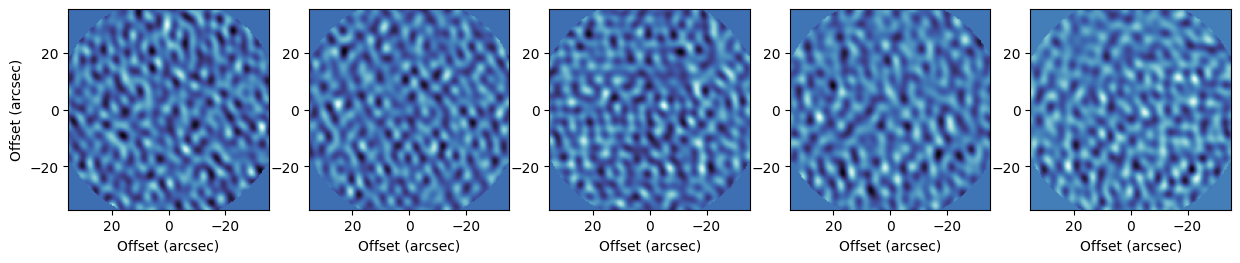

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(15,3))
ax[0].imshow(cube.data[0],cmap=cmocean.cm.ice,origin='lower',extent=cube.extent)
ax[1].imshow(cube.data[1],cmap=cmocean.cm.ice,origin='lower',extent=cube.extent)
ax[2].imshow(cube.data[2],cmap=cmocean.cm.ice,origin='lower',extent=cube.extent)
ax[3].imshow(cube.data[3],cmap=cmocean.cm.ice,origin='lower',extent=cube.extent)
ax[4].imshow(cube.data[4],cmap=cmocean.cm.ice,origin='lower',extent=cube.extent)
ax[0].set_xlabel('Offset (arcsec)'), ax[0].set_ylabel('Offset (arcsec)')
ax[1].set_xlabel('Offset (arcsec)'),ax[2].set_xlabel('Offset (arcsec)'),ax[3].set_xlabel('Offset (arcsec)'),ax[4].set_xlabel('Offset (arcsec)')

If you go far enough into the cube you will see emission appear over a wide range of channels, and then fade out again. This is due to the line having a velocity width that is many times wider than the velocity (or channel) width of our data. This line is therefore spectrally resolved. What you will have also seen is that the position and size of the emission changes with channel too. This is because the line is also spatially resolved.

The channels containing line emission only spans a small range within the cube due to how this was imaged (using CASA's tclean package). When lines are imaged, we do not necessarily know a-priori where lines will appear within cubes due to these having different properties (e.g. line widths due to different rotation speeds and sky-projections, or different line centres due to having different recession velocities). So typically cubes are imaged to contain enough data to fully cover the line to avoid throwing emission away. It is also important often to understand the noise properties of our data in a region away from the line; and so cubes might be many times wider than the line width to provide better estimates of the typical uncertainties in the locations of emission.

### Step B2: imaging moment maps -- part one Moment-0

You might imagine that if you have lots of independent data points, stacking these to reduce their errors can enhance signal-to-noise estimates. This type of process can be done with 2-D data, and one way in which this is achieved is via the creation of 'moment' maps. Simply put, these are different ways to integrate the emission in a datacube to image different physical properties of the data.

This might sound complicated, but there are lots of excellent public tools that allow you to do this.
We will first use the 'bettermoments' package to do this (Teague & Foreman-Mackey 2018: https://bettermoments.readthedocs.io/en/latest/index.html). 

We will start by making a 'Moment-0' map. This map is simply the 'velocity-integrated intensity map'. Given our maps contain channels of equal width, this is simply like collapsing all the channels in the z-axis into a single frame. Note the units will account for the total velocity width over which we are integrating (i.e. a map with a z axis of meters/second and x-y intensity units of Jy/beam, will yield a moment-0 map with units Jy/beam m/s).

I have loaded in a first example of this for you to try. 
Take a look at the code, and see how this runs.

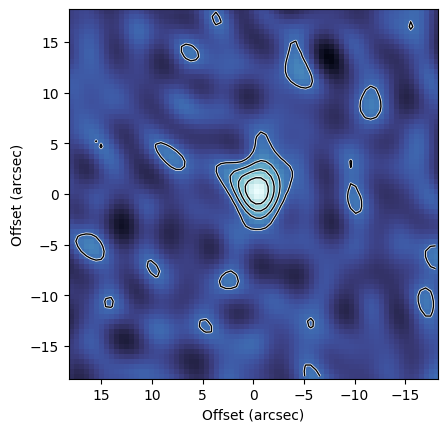

In [36]:
data, velax = bm.load_cube(loc+file) # this produces the bm (bettermoments) class object for our data, it produces data and velocities
rms = bm.estimate_RMS(data=data, N=5) #this estimates the error in the data (before applying the masks)
moments = bm.collapse_zeroth(velax=-velax, data=data, rms=rms) # this collapses the data to produce the moment 0 map ('zeroth') and its associated error map
bm.save_to_FITS(moments=moments, method='zeroth',path=loc+file) # this simply saves the object as a new fits file

file2   = 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_M0.fits' #this is just what bettermoments saved this file as...
cubeMom = imagecube(loc+file2, FOV=36.0) # this just re-opens the file, with some amount of field of view (FOV) clipping (to save some memory)

# now we've loaded this data back in, let's plot our Moment 0 map:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(cubeMom.data, origin='lower', extent=cubeMom.extent, cmap=cmocean.cm.ice)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
mapPeak=np.amax(cubeMom.data)
ax.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[0.2*mapPeak,0.4*mapPeak,0.6*mapPeak,0.8*mapPeak],colors='w',linewidths=2)
ax.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[0.2*mapPeak,0.4*mapPeak,0.6*mapPeak,0.8*mapPeak],colors='k',linewidths=1)

So this shows that if we integrate over the complete cube, there is significant emission present at the center of the image.

I have over-plotted contours at the level of 20, 40, 60 and 80% of the line peak (pixel) in the map. We can see some noisy regions, suggesting that the significance of this line is probably about 5-10sigma or so. Significant, but as we will see, well below what the emission would suggest when averaged in a smarter way.

But what do you recall from plotting the separate channels? Do you think it makes sense to include *every* single channel in our moment map intergation?

Let's see about whether there's a more sensible choice to maximise the SNR...

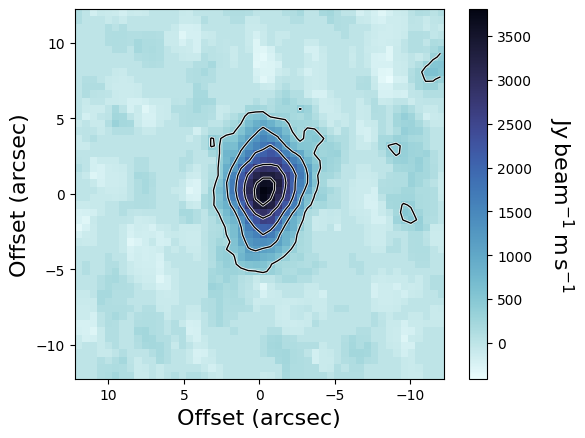

In [37]:
#imaged line... this uses bettermoments to make a 'Moment 0 map' -- the velocity-integrated intensity map
data, velax = bm.load_cube(loc+file) # this produces the bm (bettermoments) class object for our data

user_mask = bm.get_user_mask(data=data, user_mask_path=None)
smoothed_data = bm.smooth_data(data=data, smooth=1, polyorder=0)
rms_smoothed = bm.estimate_RMS(data=smoothed_data, N=5) # this smoothes over N=5 channels
rms = bm.estimate_RMS(data=data, N=5) #this estimates the error in the data (before applying the masks)

threshold_mask = bm.get_threshold_mask(data=data,
                                       clip=2.0, # this is a 2sigma clip
                                       smooth_threshold_mask=0.0) # here we define a 2-sigma clip to throw away noise artefacts

channel_mask = bm.get_channel_mask(data=data,
                                   firstchannel=8,
                                   lastchannel=29) # here we throw away all channels outside of the line width


# !!! if this choice of channel cuts doesn't make sense: trial plotting the cube frames, *after* we've applied the rms smoothing and threshold masks

# Bettermoments gives us a quick way to combine masks into a single mask: 
mask = bm.get_combined_mask(user_mask=user_mask,
                            threshold_mask=threshold_mask,
                            channel_mask=channel_mask,
                            combine='and')

masked_data = smoothed_data * mask #now we mask the data accordingly (here to the smoothed data)
moments = bm.collapse_zeroth(velax=-velax, data=masked_data, rms=rms) # and re-collapse into a moment 0 map...
bm.save_to_FITS(moments=moments, method='zeroth',path=loc+file) # we can save over the previous file as this is the one we care about keeping

file2   = 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_M0.fits'
cubeMom = imagecube(loc+file2, FOV=24.0)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(cubeMom.data, origin='lower', extent=cubeMom.extent, cmap=cmocean.cm.ice_r)
im = ax.imshow(cubeMom.data, origin='lower', extent=cubeMom.extent, cmap=cmocean.cm.ice_r)
ax.set_xlabel('Offset (arcsec)',fontsize=16)
ax.set_ylabel('Offset (arcsec)',fontsize=16)
fig.colorbar(im)
ax.text(x=-19,y=-6,s=r'Jy$\,$beam$^{-1}\,$m$\,$s$^{-1}$',rotation=270,fontsize=16)
mapPeak=np.amax(cubeMom.data)
ax.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[0.1*mapPeak, 0.3*mapPeak,0.5*mapPeak,0.7*mapPeak,0.9*mapPeak],colors='w',linewidths=2)
ax.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[0.1*mapPeak, 0.3*mapPeak,0.5*mapPeak,0.7*mapPeak,0.9*mapPeak],colors='k',linewidths=1)

Wow! The SNR of this map is way higher (more like 20-30 sigma!). How? Well, we ignored all the channels where there was no emission. We used those channels to measure the RMS. We also smoothed channels, and applied SNR clipping: all of which combined, preferentially boosts line signal. :)

To convince yourself we've been able to replicate a published science product, take a look at Figure 1 in Monsch et al. 2024 (lower right).

We've used a subtly different FOV trim, and we're also not over-plotting the orange continuum, but we are otherwise 100% reproducing that fig.

If you want to trial out different clipping, RMS choices, channel cuts, go ahead! Remember to save this choice though since we are aiming
to replicate other figures, which come from this same map...

### Step B3: imaging moment maps -- part two Moment-1, 2, 8 and 9 maps

None of these were presented in Monsch et al. 2024, but let's make a few other moment maps for fun here to see how else we can cut this data up...

Note the units can get peculiar, and the integrations may be non-standard. I'd recommend taking a read through Rich's description of these on his web page to get a better feel for how pixels and velocities are being used here: https://bettermoments.readthedocs.io/en/latest/user/methods.html

(Text(0.5, 0, 'Offset (arcsec)'),
 Text(0.5, 0, 'Offset (arcsec)'),
 Text(0.5, 0, 'Offset (arcsec)'))

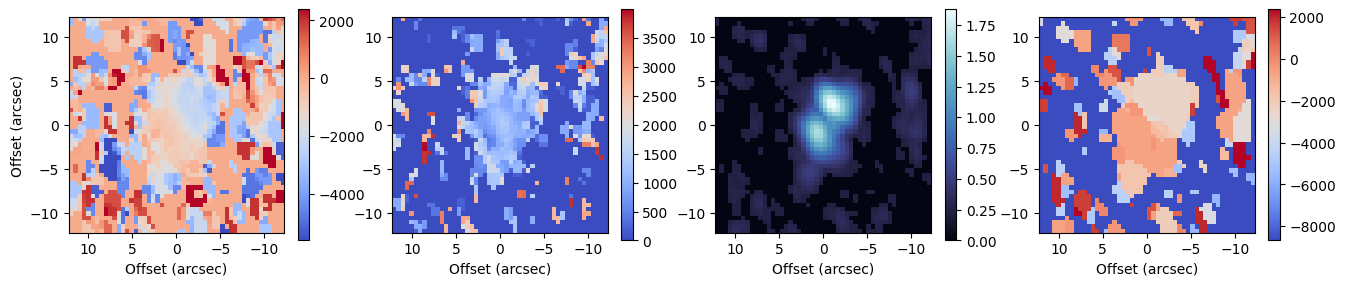

In [38]:
# previously we used the collapse_zeroth argument in bettermoments; we can also collapse first, second, eighth, ninth, and maximum. 
# What do these look like?
moment1 = bm.collapse_first(velax=-velax, data=masked_data, rms=rms) # and re-collapse into a moment 1 map...
moment2 = bm.collapse_second(velax=-velax, data=masked_data, rms=rms) # and re-collapse into a moment 2 map...
moment8 = bm.collapse_eighth(velax=-velax, data=masked_data, rms=rms) # and re-collapse into a moment 8 map...
moment9 = bm.collapse_ninth(velax=-velax, data=masked_data, rms=rms) # and re-collapse into a moment 9 map...

# save files & re-open, as it is good practice to do so
bm.save_to_FITS(moments=moment1, method='first',  path=loc+file) # we can save over the previous file as this is the one we care about keeping
bm.save_to_FITS(moments=moment2, method='second', path=loc+file) # we can save over the previous file as this is the one we care about keeping
bm.save_to_FITS(moments=moment8, method='eighth', path=loc+file) # we can save over the previous file as this is the one we care about keeping
bm.save_to_FITS(moments=moment9, method='ninth',  path=loc+file) # we can save over the previous file as this is the one we care about keeping
file_M1   = 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_M1.fits'
file_M2   = 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_M2.fits'
file_M8   = 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_M8.fits'
file_M9   = 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_M9.fits'
cubeMom_1 = imagecube(loc+file_M1, FOV=24.0)
cubeMom_2 = imagecube(loc+file_M2, FOV=24.0)
cubeMom_8 = imagecube(loc+file_M8, FOV=24.0)
cubeMom_9 = imagecube(loc+file_M9, FOV=24.0)

fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(16,3))
im1=ax[0].imshow(cubeMom_1.data, cmap='coolwarm', origin='lower', extent=cubeMom_1.extent)
im2=ax[1].imshow(cubeMom_2.data, cmap='coolwarm', origin='lower', extent=cubeMom_2.extent)
im3=ax[2].imshow(cubeMom_8.data, cmap=cmocean.cm.ice, origin='lower', extent=cubeMom_8.extent)
im4=ax[3].imshow(cubeMom_9.data, cmap='coolwarm', origin='lower', extent=cubeMom_9.extent)
fig.colorbar(im1)
fig.colorbar(im2)
fig.colorbar(im3)
fig.colorbar(im4)
ax[0].set_xlabel('Offset (arcsec)'), ax[0].set_ylabel('Offset (arcsec)')
ax[1].set_xlabel('Offset (arcsec)'),ax[2].set_xlabel('Offset (arcsec)'),ax[3].set_xlabel('Offset (arcsec)')

In brief:

Moment 1 -- is the intensity weighted *average velocity*

Moment 2 -- is the intensity-weighted average velocity *dispersion*

Moment 8 -- is the *peak* value along the provided axis (here we use the velax)

Moment 9 -- is the *velocity* of the peak intensity along the provided axis (here we also used the velax)


### Step B4: imaging moment maps -- arbitrary moment maps (extension exercise)

Bettermoments also allows other methods to collapse data. I have loaded some of these in already for you. One in particular takes some time to run as this fits a model for every channel in the cube.

 99%|█████████▉| 128/129 [00:20<00:00,  5.98it/s]

100%|██████████| 129/129 [00:20<00:00,  6.16it/s]


(Text(0.5, 0, 'Offset (arcsec)'),
 Text(0.5, 0, 'Offset (arcsec)'),
 Text(0.5, 0, 'Offset (arcsec)'))

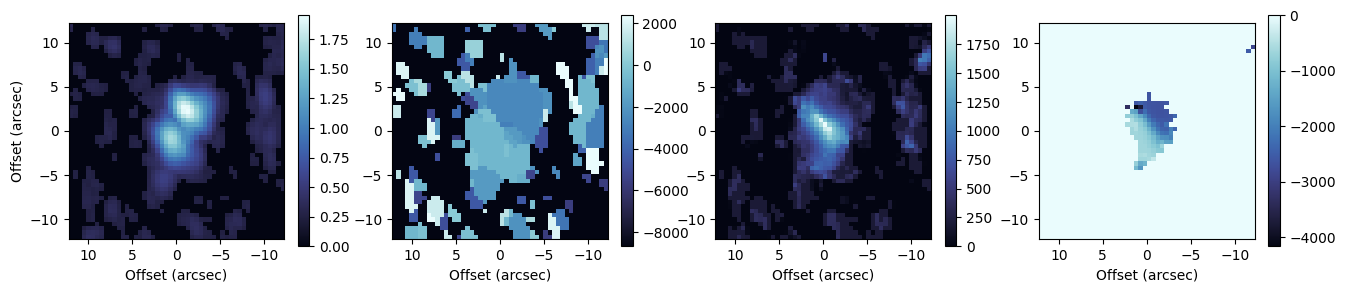

In [39]:
#Bettermoments also allows other collapses...
momentQ = bm.collapse_quadratic(velax=-velax, data=masked_data, rms=rms) # and re-collapse into a moment map via a quadratic method...
momentM = bm.collapse_maximum(velax=-velax, data=masked_data, rms=rms) # and re-collapse into a maximum moment map...
momentW = bm.collapse_width(velax=-velax, data=masked_data, rms=rms) # and re-collapse into a width integrated moment map...
momentG = bm.collapse_gaussian(velax=-velax, data=masked_data, rms=rms) # and re-collapse into a Gaussian moment map...

bm.save_to_FITS(moments=momentQ, method='quadratic', path=loc+file) # we can save over the previous file as this is the one we care about keeping
bm.save_to_FITS(moments=momentM, method='maximum',   path=loc+file) # we can save over the previous file as this is the one we care about keeping
bm.save_to_FITS(moments=momentW, method='width',     path=loc+file) # we can save over the previous file as this is the one we care about keeping
bm.save_to_FITS(moments=momentG, method='gaussian',  path=loc+file) # we can save over the previous file as this is the one we care about keeping
file_MQ   = 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_Fnu.fits'
file_MM   = 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_M9.fits' #note also produces a Fnu map too...
file_MW   = 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_dv.fits'
file_MG   = 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_gv0.fits' #note other maps also produced...
cubeMom_Q = imagecube(loc+file_MQ, FOV=24.0)
cubeMom_M = imagecube(loc+file_MM, FOV=24.0)
cubeMom_W = imagecube(loc+file_MW, FOV=24.0)
cubeMom_G = imagecube(loc+file_MG, FOV=24.0)

fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(16,3))
im1=ax[0].imshow(cubeMom_Q.data, cmap=cmocean.cm.ice, origin='lower', extent=cubeMom_Q.extent)
im2=ax[1].imshow(cubeMom_M.data, cmap=cmocean.cm.ice, origin='lower', extent=cubeMom_M.extent)
im3=ax[2].imshow(cubeMom_W.data, cmap=cmocean.cm.ice, origin='lower', extent=cubeMom_W.extent)
im4=ax[3].imshow(cubeMom_G.data, cmap=cmocean.cm.ice, origin='lower', extent=cubeMom_9.extent)
fig.colorbar(im1)
fig.colorbar(im2)
fig.colorbar(im3)
fig.colorbar(im4)
ax[0].set_xlabel('Offset (arcsec)'), ax[0].set_ylabel('Offset (arcsec)')
ax[1].set_xlabel('Offset (arcsec)'),ax[2].set_xlabel('Offset (arcsec)'),ax[3].set_xlabel('Offset (arcsec)')

In brief:

Moment Q -- is the quadratic collapse method; provides the sub-channel precision of bettermoments.collapse_cube.collapse_first() with the robustness to noise from bettermoments.collapse_cube.collapse_ninth()

Moment M -- is the result of both bettermoments.collapse_cube.collapse_eighth() and bettermoments.collapse_cube.collapse_ninth()... so this is provided to simplify getting both of those outputs!

Moment W -- is the effective width, a rescaled ratio of the integrated intensity and the line peak

Moment G -- is a collapse found by fitting a Gaussian line profile to each pixel. This function is a wrapper of collapse_analytical

# Summary
Here we've successfully reproduced Fig 1 in Monsch et al. and also produced some brand new plots. Of interest is the peculiar tail feature that appears to extend southwards in the final moment maps... We'll return to investigate this later on.

# Stage C: Imaging data in 1-dimension

### Step C1: Extracting line profiles

Now that we've understood how to get moment maps from data cubes, we should trial extracting profiles from data cubes.
Gofish () is another excellent open source tool that allows us to do this, and usefully -- given this is a protoplanetary disk -- enables Keplerian masks to be utilized with reference to the expected kinematics of the source we are analysing.

To make sure we are working on the right data again, let's just re-load in the data cube (in case we over-wrote this earlier on)...

In [40]:
loc='../data/'
file='DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image.fits' # this is the full data cube
cube = imagecube(loc+file, FOV=22.0) #FOV applies a cut on the data to speed up run time

Although we didn't discuss where the imagecube function comes from -- this is in fact from the goFish package.
This produces a 'cube' class object on which the gofish package allows one to extract spectra.
The most common type of spectra we make are integrated line spectra, assuming some aperture through the cube -- which we can select with reference to our source geometry and data properties. In Monsch et al. the source is analysed as having an inclination of ~80 degrees, and a position angle of 342degrees.

So, for example, if we want to extract a spectrum from a radius of 0--200 arcseconds we simply specify:

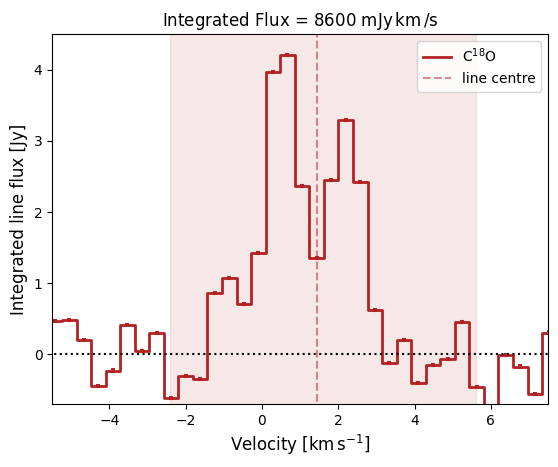

In [41]:
r_min, r_max = 0.0,200.0    # We will average the spectrum from 0--200'' (arcsec)
inc, PA      = 80.0, 342.0  # The source is highly inclined to the plane of the sky [degs], and has a large rotation on the sky from North [degs]
x0, y0       = 0.0, 0.0     # the central pixel for which r=0'' is measured from
xin, yin, dyin = cube.integrated_spectrum(r_min=r_min, r_max=r_max, inc=inc,
                                          PA=PA, x0=x0, y0=y0,empirical_uncertainty=True)
                                          # xin [m/s], yin [Jy], dyin [Jy] Note Jy as now integrated unit

fig, ax0 = plt.subplots()
# given gofish auto-uses m/s and a more natural unit for our data (with channel widths 100s m/s) is km/s, we can simply divide x/1000. to convert to km/s (as below)...
ax0.errorbar(xin/1000., yin, dyin, fmt=' ', capsize=1.5, capthick=1.5, color='firebrick', lw=1.0) #note only works when mstar and dist are called
ax0.step(xin/1000., yin, where='mid', color='firebrick', lw=2.0,label=r'C$^{18}$O')
ax0.plot([-100,100],[0.0,0.0],color='k',ls=':')
ax0.plot([1.43,1.43],[-5,5],color='firebrick',ls='--',alpha=0.5,label='line centre')
plt.fill_between([-2.4,5.6],[-1,-1],[5,5],color='firebrick',alpha=0.1) #this spans the complete line width
ax0.set_title(r'Integrated Flux = {:.0f} mJy$\,$km$\,$/s'.format(np.round(np.trapz(yin, xin),-2)), fontsize=12)

ax0.set_xlabel(r'Velocity [km$\,$s$^{-1}$]', fontsize=12)
ax0.set_ylabel(r'Integrated line flux [Jy]', fontsize=12)
plt.xlim(-5.5,7.5),plt.ylim(-0.7,4.5)
plt.legend()
#print(xin)

Now check out the same figure in Monsch et al. 2024 -- pretty convincing, huh? 
If you are not yet convinced, you can re-color this with the blue 'C0' color and scale the axes to how this was presented in the paper.

Note the features of this plot. 

-- we see the expected double peak velocity profile (for a disk in rotation, we expect a blue-shifted and red-shifted peak in the CO gas).

-- the line centre (~1.6km/s) and width (~5km/s) can be used to estimate the recession velocity and rotation speed of the gas respectively.

-- the total flux (which we integrate under the curve; 8.6 Jy km/s) can be used to estimate the total amount of C18O in the system (and by extension, and with many assumptions) the total CO mass, total gas mass, and then total disk mass.


### Step C2: Keplerian masks
Now, let's the try above exercise and see if we can find a sensible Keplerian mask to extract the same flux...
All we must specify in addition is the stellar mass and the distance to the source; along with the disk geometry, these uniquely define the velocity grid over which any disk in Keplerian rotation would be mapped to. A good map should return the same flux as our simple aperture extraction, and produce a much more sharply defined peak (at the line centre) as a result of the extraction which will effectively shift pixels from their red/blue shifted locations into a single velocity location (i.e., this process will alter the line shape).

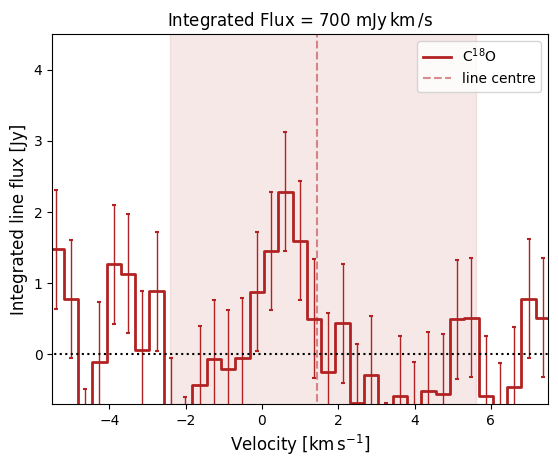

In [42]:
mstar=3.5
dist = 400.0
xin, yin, dyin = cube.integrated_spectrum(r_min=r_min, r_max=r_max, inc=inc,
                                          PA=PA, x0=x0, y0=y0,empirical_uncertainty=True,
                                          mstar=mstar, dist=dist) #we have now provided the crucial ingredients to build a Keplerian mask

fig, ax0 = plt.subplots()
ax0.errorbar(xin/1000., yin, dyin, fmt=' ', capsize=1.5, capthick=1.5, color='firebrick', lw=1.0) #note only works when mstar and dist are called
ax0.step(xin/1000., yin, where='mid', color='firebrick', lw=2.0,label=r'C$^{18}$O')
ax0.plot([-100,100],[0.0,0.0],color='k',ls=':')
ax0.plot([1.43,1.43],[-5,5],color='firebrick',ls='--',alpha=0.5,label='line centre')
plt.fill_between([-2.4,5.6],[-1,-1],[5,5],color='firebrick',alpha=0.1) #this spans the complete line width
ax0.set_title(r'Integrated Flux = {:.0f} mJy$\,$km$\,$/s'.format(np.round(np.trapz(yin, xin),-2)), fontsize=12)

ax0.set_xlabel(r'Velocity [km$\,$s$^{-1}$]', fontsize=12)
ax0.set_ylabel(r'Integrated line flux [Jy]', fontsize=12)
plt.xlim(-5.5,7.5),plt.ylim(-0.7,4.5)
plt.legend()

Hm! Well that didn't work. We've lost about 90% of the flux! 

What could have gone wrong? Let's trial a few things to see...

To start with, why would we integrate over such a large region of the sky? This is clearly causing some issues in the program, as it is throwing a bunch of errors out at large distances. Secondly, could the distance and stellar mass be wrong? Let's just alter the rmax first and see.

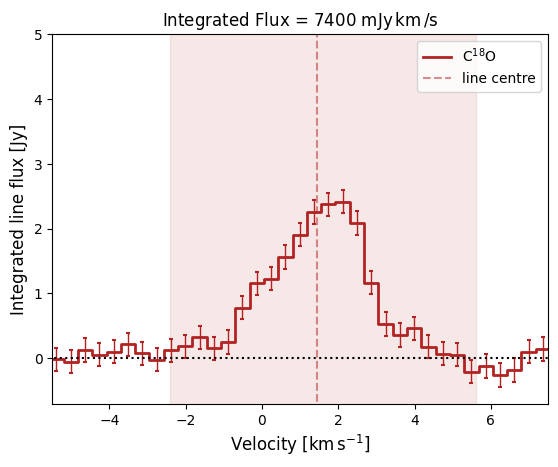

In [43]:
r_min, r_max = 0.0,  15#,150.0    # min and max radial extents to extract emission from (arcsec)
inc, PA      = 80.0, 342.0 # Trialling a lower inclination, we find this improves the picture... Why?
mstar, dist  = 3.5,  400.   # Note that there is a linear degeneracy between mstar and dist. You can prove this to yourself for bodies with fixed rotating speeds about a central potential mass.
x0, y0       = 0.0,  0.0  # measured from the continuum data: 0.2, -0.65

xin, yin, dyin = cube.integrated_spectrum(r_min=r_min, r_max=r_max, inc=inc,
                                          PA=PA, x0=x0, y0=y0,empirical_uncertainty=True,
                                          mstar=mstar, dist=dist) #we have now provided the crucial ingredients to build a Keplerian mask

fig, ax0 = plt.subplots()
ax0.errorbar(xin/1000., yin, dyin, fmt=' ', capsize=1.5, capthick=1.5, color='firebrick', lw=1.0) #note only works when mstar and dist are called
ax0.step(xin/1000., yin, where='mid', color='firebrick', lw=2.0,label=r'C$^{18}$O')
ax0.plot([-100,100],[0.0,0.0],color='k',ls=':')
ax0.plot([1.43,1.43],[-5,5],color='firebrick',ls='--',alpha=0.5,label='line centre')
plt.fill_between([-2.4,5.6],[-1,-1],[5,5],color='firebrick',alpha=0.1) #this spans the complete line width
ax0.set_title(r'Integrated Flux = {:.0f} mJy$\,$km$\,$/s'.format(np.round(np.trapz(yin, xin),-2)), fontsize=12)

ax0.set_xlabel(r'Velocity [km$\,$s$^{-1}$]', fontsize=12)
ax0.set_ylabel(r'Integrated line flux [Jy]', fontsize=12)
plt.xlim(-5.5,7.5),plt.ylim(-0.7,5)
plt.legend()

Well, that's better. Not perfect, but better. 

Immediately you can see that gradually more of the more red-shifted and blue-shifted data are being pushed towards the line centre. Due to data imperfections at this resolution (and unresolved source structures which we are not accounting for), you can never make this perfect. But this is now within about ~80-90% of the total flux we measured earlier. 

### Step C3: getting the inclination right

Let's now take a step back though and understand what gofish means when it asks for an inclination.

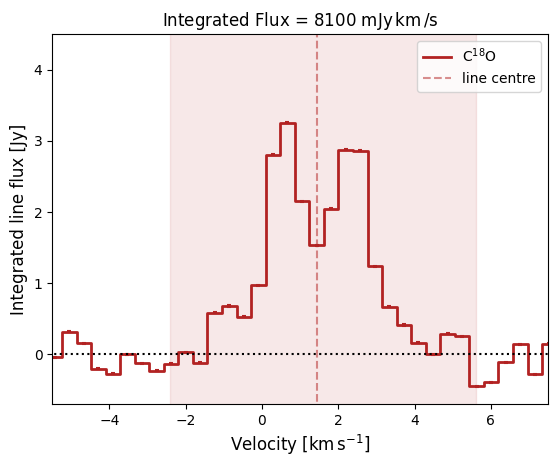

In [44]:
r_min, r_max = 0.0,8.0    # We will average the spectrum from 0--8'' (arcsec)
inc, PA      = 45.0, 342.0  # Let's now use a much lower inclination...
x0, y0       = 0.0, 0.0     # the central pixel for which r=0'' is measured from
xin, yin, dyin = cube.integrated_spectrum(r_min=r_min, r_max=r_max, inc=inc,
                                          PA=PA, x0=x0, y0=y0,empirical_uncertainty=True)
                                          # xin [m/s], yin [Jy], dyin [Jy] Note Jy as now integrated unit

fig, ax0 = plt.subplots()
# given gofish auto-uses m/s and a more natural unit for our data (with channel widths 100s m/s) is km/s, we can simply divide x/1000. to convert to km/s (as below)...
ax0.errorbar(xin/1000., yin, dyin, fmt=' ', capsize=1.5, capthick=1.5, color='firebrick', lw=1.0) #note only works when mstar and dist are called
ax0.step(xin/1000., yin, where='mid', color='firebrick', lw=2.0,label=r'C$^{18}$O')
ax0.plot([-100,100],[0.0,0.0],color='k',ls=':')
ax0.plot([1.43,1.43],[-5,5],color='firebrick',ls='--',alpha=0.5,label='line centre')
plt.fill_between([-2.4,5.6],[-1,-1],[5,5],color='firebrick',alpha=0.1) #this spans the complete line width
ax0.set_title(r'Integrated Flux = {:.0f} mJy$\,$km$\,$/s'.format(np.round(np.trapz(yin, xin),-2)), fontsize=12)

ax0.set_xlabel(r'Velocity [km$\,$s$^{-1}$]', fontsize=12)
ax0.set_ylabel(r'Integrated line flux [Jy]', fontsize=12)
plt.xlim(-5.5,7.5),plt.ylim(-0.7,4.5)
plt.legend()
#print(xin)

Test what happens now if you alter the inclination with a 8'' aperture max radius with either 80 degrees inclination, or with 45 degrees inclination.

...

...

...

More flux is measured with the *non-physical* inclination! 

This is an important lesson in data analysis of low resolution interferometric cubes: the data resolution of our map is 4.1''x 2.7'', and there are only a few radial beams of data. As such, an 80-degree inclined disk can be smoothed into a morphology with a much smaller axis ratio (that would appear as a resolved ~45 degree inclined blob...).

To accurately extract the total flux, one therefore needs to inspect the actual data with respect to the extraction mask. We will use our moment 0 map from earlier and over-plot these different gofish apertures to see which pixles this is picking up emission from... 

Text(11.5, 10, '80.0$^\\circ$')

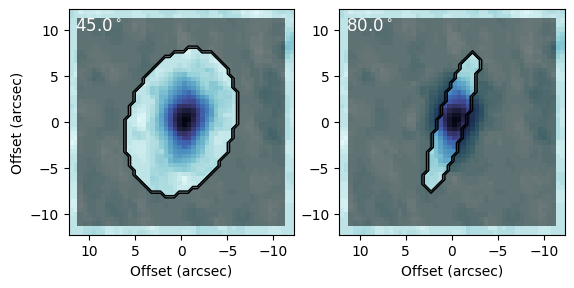

In [45]:
file2   = 'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_M0.fits' #this is just what bettermoments saved our Mom-0 as...
cubeMom = imagecube(loc+file2, FOV=24.0)

inc1,inc2=45.,80.

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(cubeMom.data, origin='lower', extent=cubeMom.extent, cmap=cmocean.cm.ice_r)
cube.plot_mask(ax=ax[0], r_min=r_min, r_max=r_max, PA_min=-180.0, PA_max=180.0, mask_frame='disk',inc=inc1, PA=PA)
ax[0].set_xlabel('Offset (arcsec)')
ax[0].set_ylabel('Offset (arcsec)')

ax[1].imshow(cubeMom.data, origin='lower', extent=cubeMom.extent,cmap=cmocean.cm.ice_r)
cube.plot_mask(ax=ax[1], r_min=r_min, r_max=r_max, PA_min=-180.0, PA_max=180.0, mask_frame='disk',inc=inc2, PA=PA)
ax[1].set_xlabel('Offset (arcsec)')
ax[0].text(11.5,10,s=str(inc1)+r'$^\circ$',color='w',fontsize=12)
ax[1].text(11.5,10,s=str(inc2)+r'$^\circ$',color='w',fontsize=12)

So you can see that although in the case that we did not use a Keplerian mask, all the emission remained within the mask if we selected a aperture that covered the full disk extent. Due to the noise properties of interferometric maps, it is often better to integrate total fluxes in pixels as close in to the centre of the map as possible, since noise scales with the 'primary beam', which is a effectively a Gaussian map with FWHM ~ lambda/D (D=dish diameter). As such, although we might sum to get the same total flux using a much larger aperture (with i=80degrees, and rout=200'') we are likely to be less skewed by noise if here we used i=45degrees and rout=8''.

Further complexity arises however if one then shifts this data into the disk frame, since a 45 degree inclined disk would not match the velocities well, and so much of the emission is then not picked up. In this instance, an 80 degree disk is required to recover as much flux as possible.

So: BE CAREFUL how you specify your masks and be sure to check you are not over-clipping / under-masking. Always image your data and apertures.

### Step C5: Image centering
gofish also lets us estimate the central pixel of the line to more accurately pull out total fluxes.

This can be called with:

Peak SNR at (x0, y0) = (1.71", -3.43").


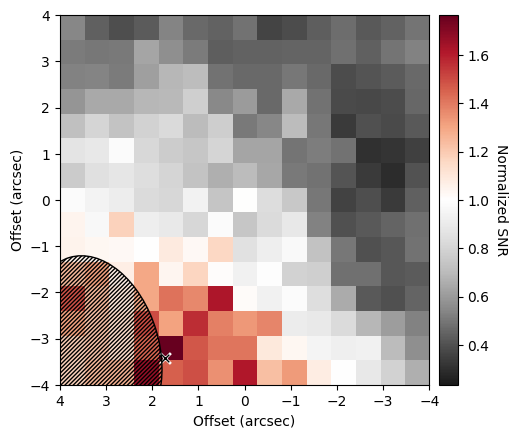

In [46]:
x0s, y0s, SNR = cube.find_center(dx=4., dy=4., r_min=r_min, r_max=r_max,
                                 SNR='peak', inc=inc, PA=PA, mstar=mstar, dist=dist, resample=10)

# Note this function can take time to run for progressively larger maps. 

Text(0, 0.5, 'Offset (arcsec)')

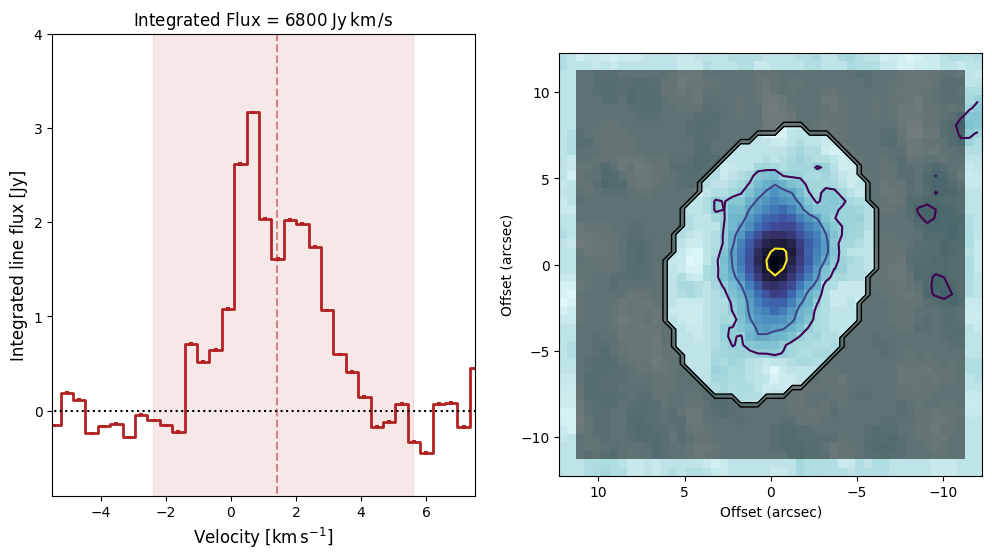

In [47]:
# So now we can redo our earlier plots and use this updated set of values x0,y0
#print(SNR)
r_min, r_max = 0.0,8.0
inc, PA      = 45.0, 342.0
mstar, dist  = 3.0, 400.
x0, y0       = 1.71, -3.43  # above...

xin, yin, dyin = cube.integrated_spectrum(r_min=r_min, r_max=r_max, inc=inc,
                                          PA=PA, x0=x0, y0=y0,empirical_uncertainty=True)#, mstar=mstar, dist=dist)
                                          # xin [m/s], yin [Jy], dyin [Jy] Note Jy as now integrated unit
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax[0].errorbar(xin/1000., yin, dyin, fmt=' ', capsize=1.5, capthick=1.5, color='firebrick', lw=1.0) #note only works when mstar and dist are called
ax[0].step(xin/1000., yin, where='mid', color='firebrick', lw=2.0,label=r'C$^{18}$O')
ax[0].plot([-100,100],[0.0,0.0],color='k',ls=':')
ax[0].plot([1.43,1.43],[-5,5],color='firebrick',ls='--',alpha=0.5,label='line centre')
ax[0].fill_between([-2.4,5.6],[-1,-1],[5,5],color='firebrick',alpha=0.1) #this spans the complete line width
ax[0].set_title(r'Integrated Flux = {:.0f} Jy$\,$km$\,$/s'.format(np.round(np.trapz(yin, xin),-2)), fontsize=12)

ax[0].set_xlabel(r'Velocity [km$\,$s$^{-1}$]', fontsize=12)
ax[0].set_ylabel(r'Integrated line flux [Jy]', fontsize=12)
ax[0].set_xlim(-5.5,7.5),ax[0].set_ylim(-0.9,4.0)
#plt.legend()
ax[1].imshow(cubeMom.data, origin='lower', extent=cubeMom.extent, cmap=cmocean.cm.ice_r)
ax[1].contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[350, 1000,3500])
cube.plot_mask(ax=ax[1], r_min=r_min, r_max=r_max, PA_min=-180.0, PA_max=180.0, mask_frame='disk',inc=inc, PA=PA)
ax[1].set_xlabel('Offset (arcsec)')
ax[1].set_ylabel('Offset (arcsec)')

Did this do a better job? It isn't clear. 

It looks a little low. 

And this doesn't match the continuum peak, nor what appears to be the peak pixel in the map either. So I might treat this output with suspicion for now and revert to the previous values.

Text(0, 0.5, 'Offset (arcsec)')

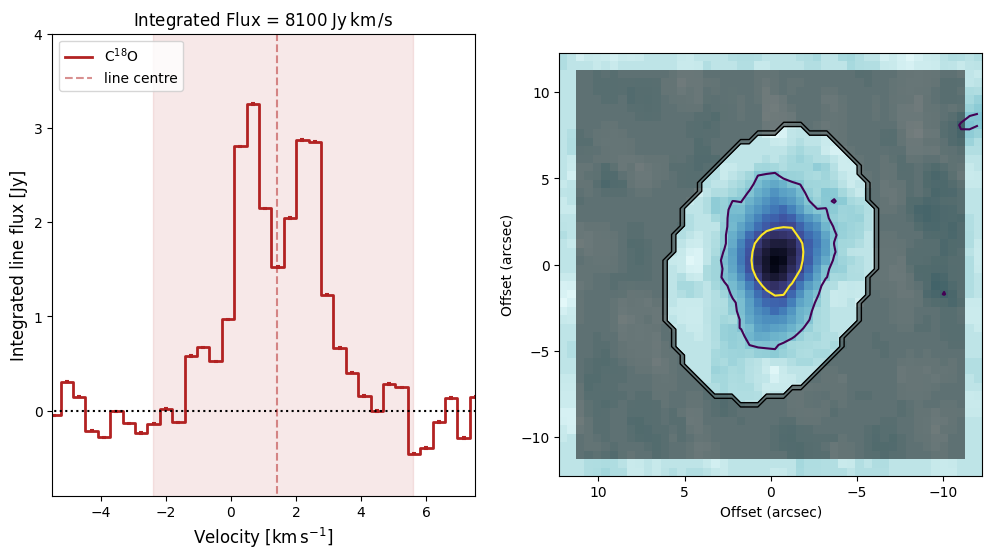

In [48]:
r_min, r_max = 0.0,8.0    # We will average the spectrum from 0--10'' (arcsec)
inc, PA      = 45.0, 342.0 # or with the lower inc...
mstar, dist  = 3.0, 330.   # The most controversial parameters. Here we take the values not presented in that paper. [Msolar], [parsecs]
x0, y0       = 0.0, 0.0  # above...

xin, yin, dyin = cube.integrated_spectrum(r_min=r_min, r_max=r_max, inc=inc,
                                          PA=PA, x0=x0, y0=y0,empirical_uncertainty=True)
                                          # xin [m/s], yin [Jy], dyin [Jy] Note Jy as now integrated unit
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax[0].errorbar(xin/1000., yin, dyin, fmt=' ', capsize=1.5, capthick=1.5, color='firebrick', lw=1.0) #note only works when mstar and dist are called
ax[0].step(xin/1000., yin, where='mid', color='firebrick', lw=2.0,label=r'C$^{18}$O')
ax[0].plot([-100,100],[0.0,0.0],color='k',ls=':')
ax[0].plot([1.43,1.43],[-5,5],color='firebrick',ls='--',alpha=0.5,label='line centre')
ax[0].fill_between([-2.4,5.6],[-1,-1],[5,5],color='firebrick',alpha=0.1) #this spans the complete line width
ax[0].set_title(r'Integrated Flux = {:.0f} Jy$\,$km$\,$/s'.format(np.round(np.trapz(yin, xin),-2)), fontsize=12)

ax[0].set_xlabel(r'Velocity [km$\,$s$^{-1}$]', fontsize=12)
ax[0].set_ylabel(r'Integrated line flux [Jy]', fontsize=12)
ax[0].set_xlim(-5.5,7.5),ax[0].set_ylim(-0.9,4.0)
ax[0].legend(loc='upper left')
ax[1].imshow(cubeMom.data, origin='lower', extent=cubeMom.extent, cmap=cmocean.cm.ice_r)
ax[1].contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[500, 2500])
cube.plot_mask(ax=ax[1], r_min=r_min, r_max=r_max, PA_min=-180.0, PA_max=180.0, mask_frame='disk',inc=inc, PA=PA)
ax[1].set_xlabel('Offset (arcsec)')
ax[1].set_ylabel('Offset (arcsec)')
 

Overall -- it appears to be very hard at this resolution to truly get a good understanding of the kinematics. Likely this is due to unresolved sub-structure in the data that is not well accounted for by a single Keplerian mask. Whilst this comlicates the analysis, this might mean that some under-lying structure is present in this data that we can hunt for... Let's now give that a go with some of the other goFish tools available to us.

# Stage D: Imaging asymmetric data

### Step D1: plotting tools to image asymmetries & sub-structures

goFish also allows us to plot tear-drop plots. Note that asymmetric emission can manifest in moment maps too (so take a look back at these and see if you think there are any significant asymmetries in our data).

If we use these with physical parameters of the disk with a tear drop plot, we see that there is some evidence of asymmetric emission.


<Axes: xlabel='Velocity (km/s)', ylabel='Radius (arcsec)'>

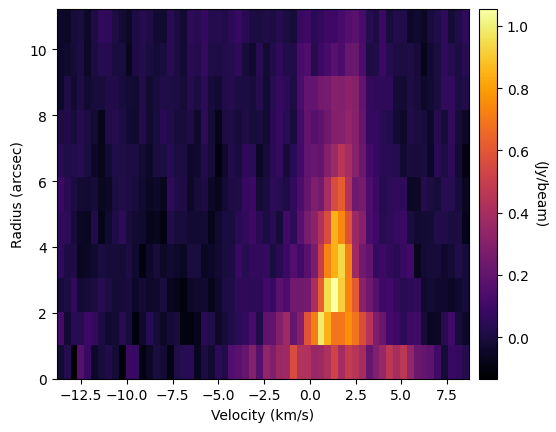

In [49]:
cube.plot_teardrop(inc=80, PA=PA, mstar=mstar, dist=dist, x0=0.0, y0=0.0)

However -- this is probably not a great way to extract sub-structure/asymmetric emission, firstly this plot is 2-dimensional, and secondly the signal-to-noise isn't exceptionally high that any asymmetries are immediately obvious.

### Stage D2: getting mean intensity 1-D profiles

In general, for low-resolution data, we might be better off first trialing to see if an average 1D profile of the data (imaged back into 2D) and then subtracted off the 2D map shows evidence of asymmetric structure. Gofish also allows us to do just this...

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0, 0.5, 'Integrated Intensity (Jy/beam m/s)')

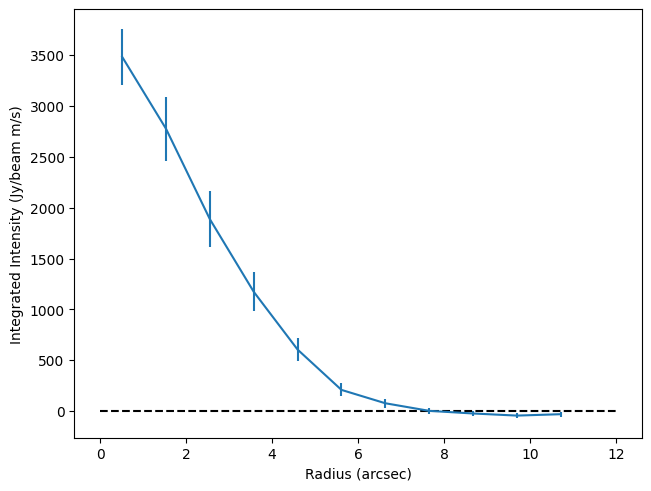

In [50]:
x0,y0=0.0, 0.0
x, y, dy = cubeMom.radial_profile(inc=45, PA=PA, x0=x0, y0=y0)
fig, ax = plt.subplots(constrained_layout=True)
ax.errorbar(x, y, dy)
ax.plot([0,12],[0,0],'--k')
ax.set_yscale('linear')
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Integrated Intensity (Jy/beam m/s)')

This produces a nice brightness profile, centred on (0,0) which shows the disk is bright out to ~7-8''. goFish has a tool background_residual which then takes this, maps it back to a 2D structure and then subtracts this from the data.

### Step D3: from profiles to 2-D empirical models

To visualise this, let's plot this empirical model (overlaid with the data contours) side by side with the residual map (and also overlaid with these contours) to see what we find...

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Net flux in map:  100.0 Jy/beam m/s


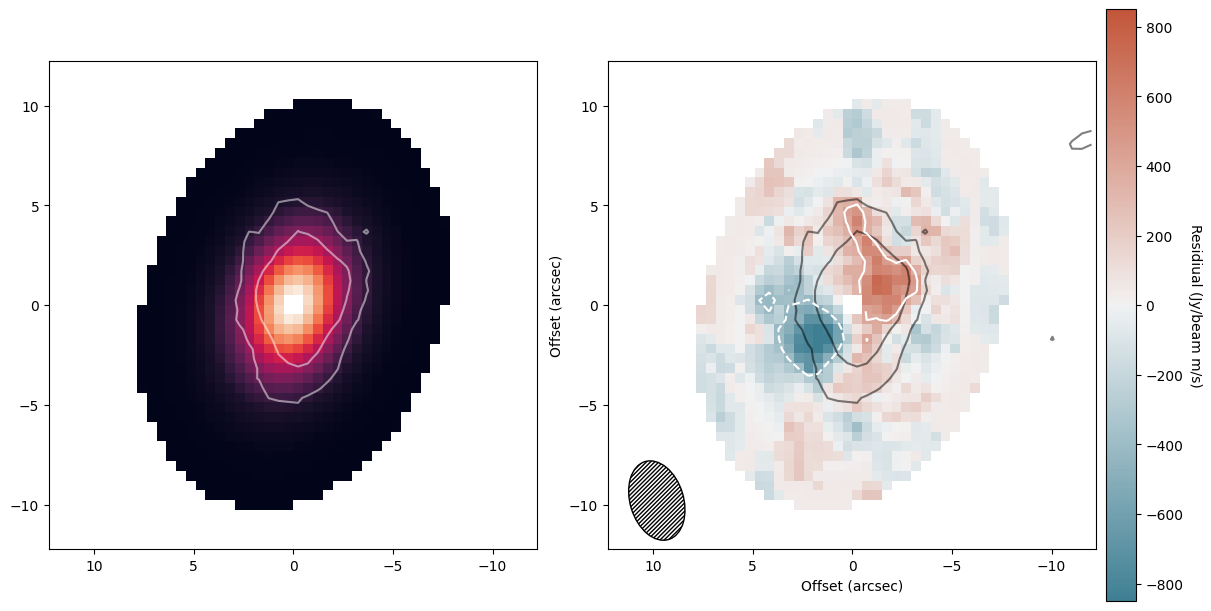

In [51]:
x0,y0=0.0, 0.0
divpal=sns.diverging_palette(220, 20, as_cmap=True)
linpal=sns.color_palette("rocket", as_cmap=True)

residual   = cubeMom.background_residual(inc=45., PA=PA, x0=x0, y0=y0)
background = cubeMom.background_residual(inc=45., PA=PA, x0=x0, y0=y0, background_only=True)
#background = cubeMom.convolve_with_beam(data=background)
vmin,vmax=-850,850
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,6))
im1 = ax1.imshow(background, origin='lower', extent=cubeMom.extent, cmap=linpal)
ax1.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[500, 1500],colors='w',alpha=0.5)
im2 = ax2.imshow(residual, origin='lower', extent=cubeMom.extent, cmap=divpal, vmin=vmin, vmax=vmax)
cb = plt.colorbar(im2, pad=0.02)
ax2.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[500, 1500],colors='k',alpha=0.5)
ax2.contour(residual, origin='lower', extent=cubeMom.extent, levels=[-400,400],colors='w',linestyle='--')
ax2.set_xlabel('Offset (arcsec)')
ax2.set_ylabel('Offset (arcsec)')
cb.set_label('Residiual (Jy/beam m/s)', rotation=270, labelpad=13)
cube.plot_beam(ax=ax2)

pixPerBeam = (4.08/0.5)*(2.68/0.5)
beamsInMap = np.count_nonzero(~np.isnan(residual)) / pixPerBeam # this accounts for beam smoothing in the data, cannot simply sum pixel vals
print('Net flux in map: ',np.round(np.nansum(residual)/beamsInMap,-2), 'Jy/beam m/s')

Well -- there are certainly some large residuals. But these could well be due to use defining a poor model. 

The only way to check this is by altering the model parameters; inc, PA, x0 and y0. Note this is not a Keplerian model, so inc can be played with readily, but I would suggest keeping PA fixed since this is relatively well known.

As a first trial, I would recommend trialling different x0 y0 values in steps of +-0.5 (the pixel sizes are 0.5''). As an example (0.5,0.5):

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Net flux in map:  100.0 Jy/beam m/s


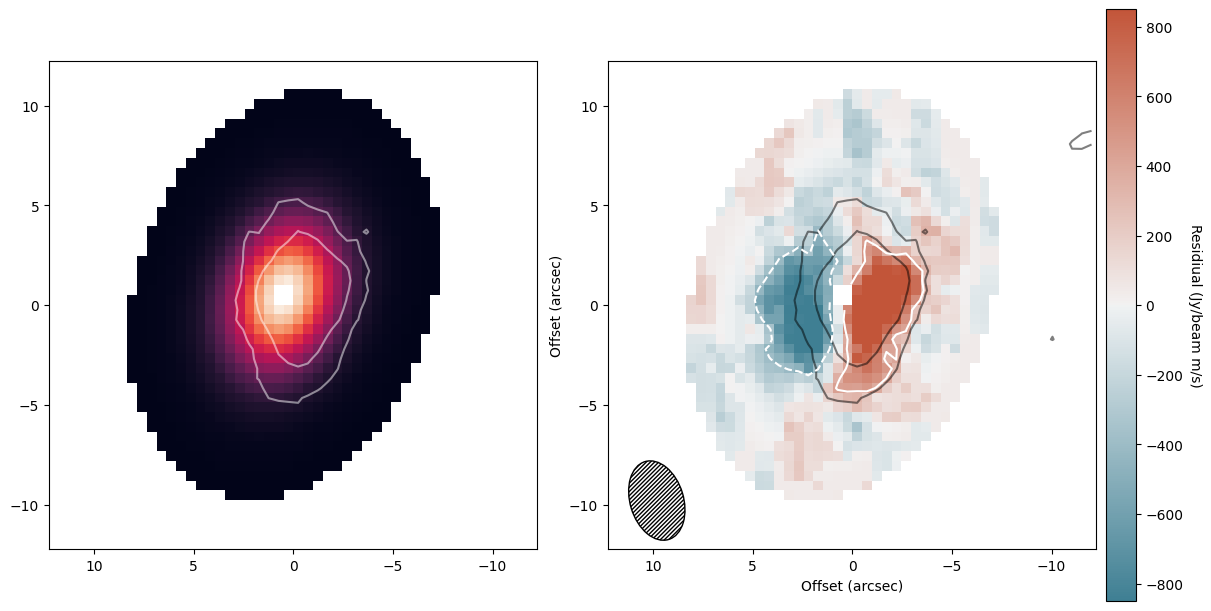

In [52]:
x0,y0=0.5, 0.5
divpal=sns.diverging_palette(220, 20, as_cmap=True)
linpal=sns.color_palette("rocket", as_cmap=True)
inc,PA = 45,342
residual   = cubeMom.background_residual(inc=inc, PA=PA, x0=x0, y0=y0)
background = cubeMom.background_residual(inc=inc, PA=PA, x0=x0, y0=y0, background_only=True)
#background = cubeMom.convolve_with_beam(data=background)
vmin,vmax=-850,850
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,6))
im1 = ax1.imshow(background, origin='lower', extent=cubeMom.extent, cmap=linpal)
ax1.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[500, 1500],colors='w',alpha=0.5)
im2 = ax2.imshow(residual, origin='lower', extent=cubeMom.extent, cmap=divpal, vmin=vmin, vmax=vmax)
cb = plt.colorbar(im2, pad=0.02)
ax2.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[500, 1500],colors='k',alpha=0.5)
ax2.contour(residual, origin='lower', extent=cubeMom.extent, levels=[-400,400],colors='w',linestyle='--')
ax2.set_xlabel('Offset (arcsec)')
ax2.set_ylabel('Offset (arcsec)')
cb.set_label('Residiual (Jy/beam m/s)', rotation=270, labelpad=13)
cube.plot_beam(ax=ax2)

pixPerBeam = (4.08/0.5)*(2.68/0.5)
beamsInMap = np.count_nonzero(~np.isnan(residual)) / pixPerBeam # this accounts for beam smoothing in the data, cannot simply sum pixel vals
print('Net flux in map: ',np.round(np.nansum(residual)/beamsInMap,-2), 'Jy/beam m/s')

Well, as a first trial, that looked worse. Can you find a solution that only yields residuals in the southern 'tail' of the disk?...

Overall there are 9 permutations, of which you have trialled 2 so far. Which one do you think demonstrates there is asymmetric emission in the disk most convincingly?

x0, y0 =  0.0,  0.0

x0, y0 =  0.0, -0.5

x0, y0 =  0.0,  0.5

x0, y0 =  0.5, -0.5

x0, y0 =  0.5,  0.5

x0, y0 =  0.5,  0.0

x0, y0 = -0.5, -0.5

x0, y0 = -0.5,  0.5

x0, y0 = -0.5,  0.0

### Step D4: Finding a best-fit model [*Advanced exercise*]

We have assumed inc=45, PA=342. But the beam properties could have altered the apparent disk orientation as well as its inclination. This could be subtle, but this is a check we should make. 

Is there a combination of inc and PA which fully removes all contours? How could you go about finding this? What values do the best job? What might this tell you about the possibility of there being asymmetric emission in these data? What might you expect the net flux in the map to be? What about the error properties? What might you have to do to the residual maps to fairly compare?

## Only proceed past here once you've had a proper think through the above...

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Net flux in map:  800.0 Jy/beam m/s
Res RMS:  121.74529184098373 Jy/beam m/s


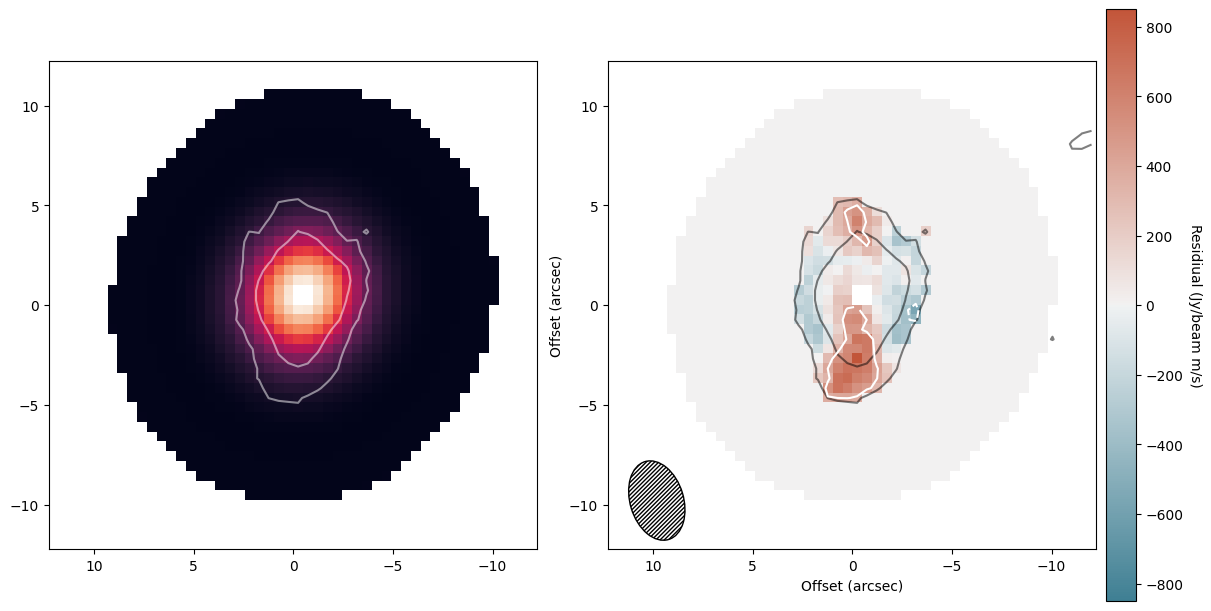

In [53]:
x0,y0=-0.5, 0.5
divpal=sns.diverging_palette(220, 20, as_cmap=True)
linpal=sns.color_palette("rocket", as_cmap=True)

inc,PA = 25, 340

residual   = cubeMom.background_residual(inc=inc, PA=PA, x0=x0, y0=y0)
background = cubeMom.background_residual(inc=inc, PA=PA, x0=x0, y0=y0, background_only=True)
#background = cubeMom.convolve_with_beam(data=background)
mask = np.where(cubeMom.data>500,1.0,0.0)
residual = np.multiply(residual,mask)


vmin,vmax=-850,850
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,6))
im1 = ax1.imshow(background, origin='lower', extent=cubeMom.extent, cmap=linpal)
ax1.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[500, 1500],colors='w',alpha=0.5)
im2 = ax2.imshow(residual, origin='lower', extent=cubeMom.extent, cmap=divpal, vmin=vmin, vmax=vmax)
cb = plt.colorbar(im2, pad=0.02)
ax2.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[500, 1500],colors='k',alpha=0.5)
ax2.contour(residual, origin='lower', extent=cubeMom.extent, levels=[-400,400],colors='w',linestyle='--')
ax2.set_xlabel('Offset (arcsec)')
ax2.set_ylabel('Offset (arcsec)')
cb.set_label('Residiual (Jy/beam m/s)', rotation=270, labelpad=13)
cube.plot_beam(ax=ax2)

pixPerBeam = (4.08/0.5)*(2.68/0.5)
beamsInMap = np.count_nonzero(~np.isnan(residual)) / pixPerBeam # this accounts for beam smoothing in the data, cannot simply sum pixel vals
print('Net flux in map: ',np.round(np.nansum(residual)/beamsInMap,-2), 'Jy/beam m/s')
print('Res RMS: ', np.nanstd(residual), 'Jy/beam m/s')

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal aver

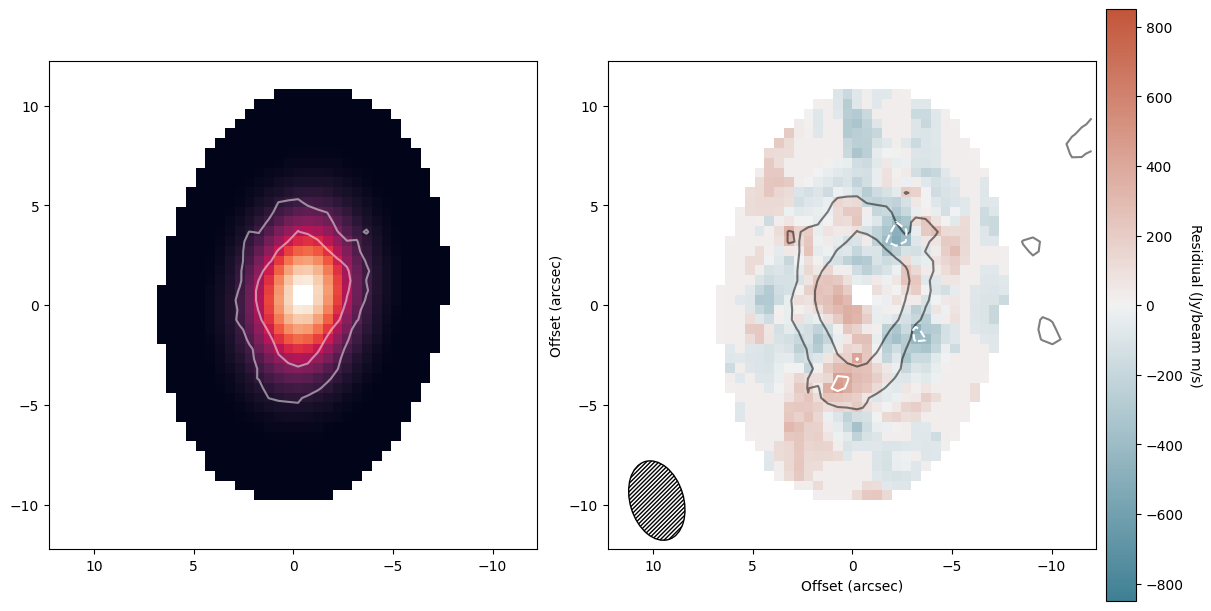

In [54]:
#One such example... finding the minima in the rms of the reisidual map, after masking all pixels beyond the outer contour boundary...
mask = np.where(cubeMom.data>500,1.0,0.0)
minResVal = 10000000000
incs = np.linspace(20.,75.,25)
PAs  = np.linspace(330.,360.,25)
for i in range(len(incs)):
  for j in range(len(PAs)):
    residual   = cubeMom.background_residual(inc=incs[i], PA=PAs[j], x0=x0, y0=y0)
    residual   = np.multiply(residual,mask)
    resval     = np.nanstd(residual)
    if resval<minResVal:
      minvals = [i,j]
      minResVal = resval
print(incs[minvals[0]],PAs[minvals[1]])

inc,PA = incs[minvals[0]],PAs[minvals[1]]

residual   = cubeMom.background_residual(inc=inc, PA=PA, x0=x0, y0=y0)
background = cubeMom.background_residual(inc=inc, PA=PA, x0=x0, y0=y0, background_only=True)
#background = cubeMom.convolve_with_beam(data=background)
mask = np.where(cubeMom.data>500,1.0,0.0)
#residual = np.multiply(residual,mask)


vmin,vmax=-850,850
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,6))
im1 = ax1.imshow(background, origin='lower', extent=cubeMom.extent, cmap=linpal)
ax1.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[500, 1500],colors='w',alpha=0.5)
im2 = ax2.imshow(residual, origin='lower', extent=cubeMom.extent, cmap=divpal, vmin=vmin, vmax=vmax)
cb = plt.colorbar(im2, pad=0.02)
ax2.contour(cubeMom.data, origin='lower', extent=cubeMom.extent, levels=[370, 1500],colors='k',alpha=0.5)
ax2.contour(residual, origin='lower', extent=cubeMom.extent, levels=[-400,400],colors='w',linestyle='--')
ax2.set_xlabel('Offset (arcsec)')
ax2.set_ylabel('Offset (arcsec)')
cb.set_label('Residiual (Jy/beam m/s)', rotation=270, labelpad=13)
cube.plot_beam(ax=ax2)

pixPerBeam = (4.08/0.5)*(2.68/0.5)
beamsInMap = np.count_nonzero(~np.isnan(residual)) / pixPerBeam # this accounts for beam smoothing in the data, cannot simply sum pixel vals
print('Net flux in map: ',np.round(np.nansum(residual)/beamsInMap,-2), 'Jy/beam m/s')
print('Res RMS: ', np.nanstd(residual), 'Jy/beam m/s')
        

So there could well be some ~significant level of emission asymmetry in this system. 

It looks like a relatively low brightness asymmetry as expected, but in comparison with the moment maps produced earlier suggests this could well be real. Pretty cool!

# Conclusion

Hopefully by this stage you have thoroughly exhausted how to cut up this single C18O map!

However: *nothing* that we have done here is particular about the choice of line, only that we sensibly account for system properties in orrder to accurately extract emission from data. As such, with any data cube with line emission (or non-detections even) you should be well-versed now to reproduce these types of analysis for different systems and/or different emission lines.